# NAFNet Online Demo on Image Denoising

## Git clone [NAFNet](https://github.com/megvii-research/NAFNet) repo

In [1]:
!git clone https://github.com/megvii-research/NAFNet
%cd NAFNet

Cloning into 'NAFNet'...
remote: Enumerating objects: 521, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 521 (delta 180), reused 142 (delta 142), pack-reused 296 (from 1)
Receiving objects: 100% (521/521), 16.19 MiB | 30.47 MiB/s, done.
Resolving deltas: 100% (277/277), done.
/content/NAFNet


## Set up the enviroment

In [2]:
!pip install -r requirements.txt
!pip install --upgrade --no-cache-dir gdown
!python3 setup.py develop --no_cuda_ext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.8/297.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 56.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 13.9 MB/s eta 0:00:00
/usr/local/lib/python3.11/dist-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running develop
/usr/local/lib/python3.11/dist-packages/setuptools/command/develop.py:41: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

       

## Download pretrained models

In [3]:
import gdown
gdown.download('https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR', "./experiments/pretrained_models/", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR
From (redirected): https://drive.google.com/uc?id=14Fht1QQJ2gMlk4N1ERCRuElg8JfjrWWR&confirm=t&uuid=8658d76d-4abf-439f-8975-3232c4be8a38
To: /content/NAFNet/experiments/pretrained_models/NAFNet-SIDD-width64.pth
100%|██████████| 464M/464M [00:10<00:00, 42.4MB/s]


'./experiments/pretrained_models/NAFNet-SIDD-width64.pth'

## Download Demo Image

In [4]:
gdown.download('https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm', "demo_input/", quiet=False)
gdown.download('https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf', "demo_input/", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1uKwZUgeGfBYLlPKllSuzgGUItlzb40hm
To: /content/NAFNet/demo_input/noisy-demo-0.png
100%|██████████| 171k/171k [00:00<00:00, 68.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ov6UqpIA6GjjJT5SdGeUAJECxka14nGf
To: /content/NAFNet/demo_input/noisy-demo-1.png
100%|██████████| 150k/150k [00:00<00:00, 63.8MB/s]


'demo_input/noisy-demo-1.png'

## Preparation

In [5]:
import torch

from basicsr.models import create_model
from basicsr.utils import img2tensor as _img2tensor, tensor2img, imwrite
from basicsr.utils.options import parse
import numpy as np
import cv2
import matplotlib.pyplot as plt

def imread(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img
def img2tensor(img, bgr2rgb=False, float32=True):
    img = img.astype(np.float32) / 255.
    return _img2tensor(img, bgr2rgb=bgr2rgb, float32=float32)

def display(img1, img2):
  fig = plt.figure(figsize=(25, 10))
  ax1 = fig.add_subplot(1, 2, 1)
  plt.title('Input image', fontsize=16)
  ax1.axis('off')
  ax2 = fig.add_subplot(1, 2, 2)
  plt.title('NAFNet output', fontsize=16)
  ax2.axis('off')
  ax1.imshow(img1)
  ax2.imshow(img2)

def single_image_inference(model, img, save_path):
      model.feed_data(data={'lq': img.unsqueeze(dim=0)})

      if model.opt['val'].get('grids', False):
          model.grids()

      model.test()

      if model.opt['val'].get('grids', False):
          model.grids_inverse()

      visuals = model.get_current_visuals()
      sr_img = tensor2img([visuals['result']])
      imwrite(sr_img, save_path)


## Create Model

In [6]:
opt_path = 'options/test/SIDD/NAFNet-width64.yml'
opt = parse(opt_path, is_train=False)
opt['dist'] = False
NAFNet = create_model(opt)

 load net keys <built-in method keys of collections.OrderedDict object at 0x7d11b4e96040>


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Inference and Show results

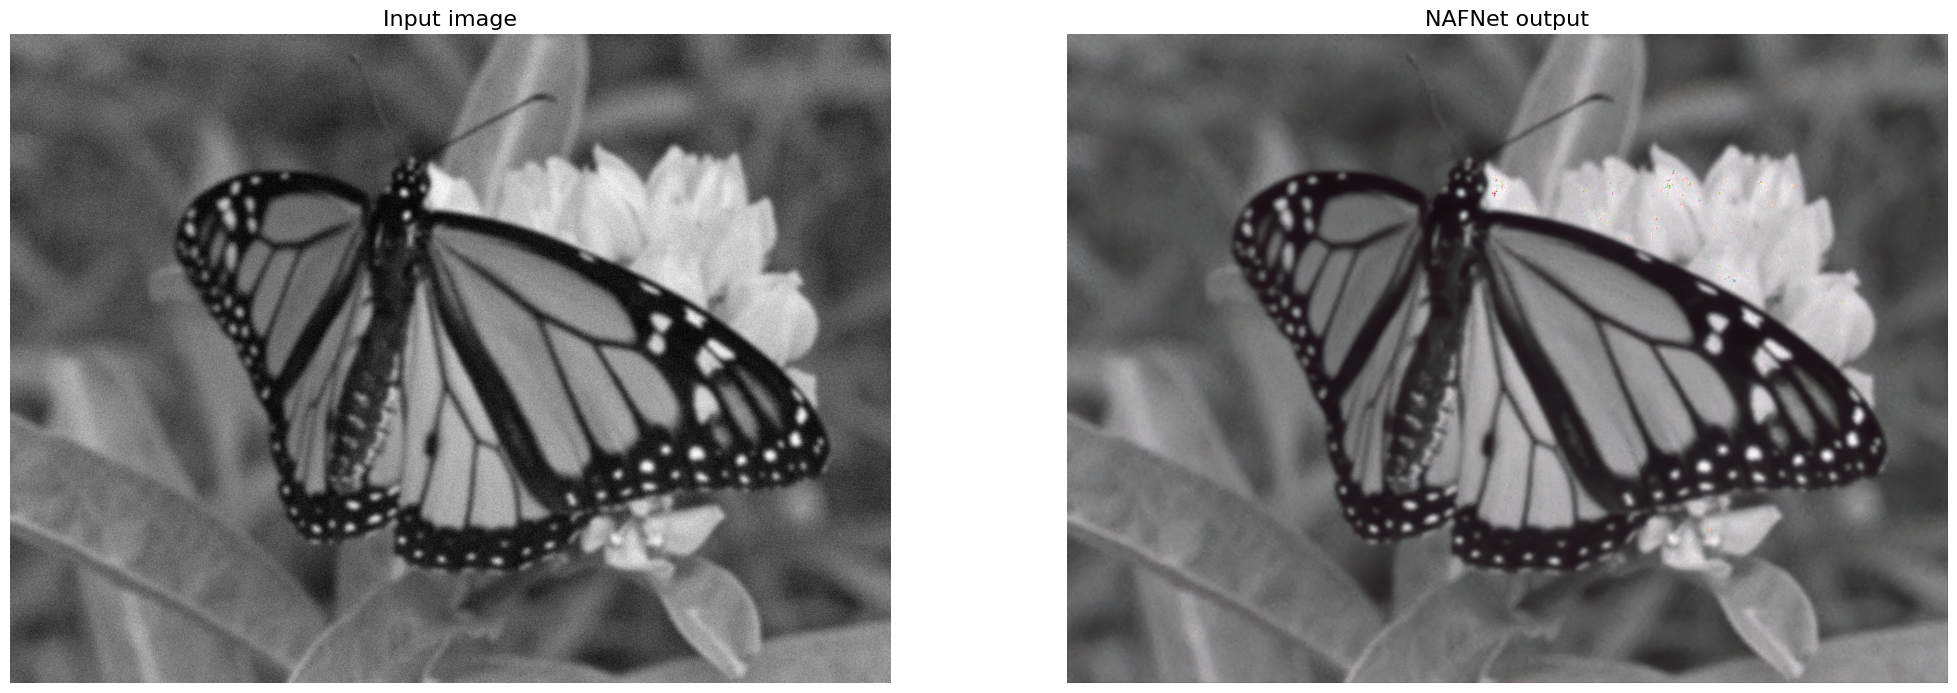

In [9]:
input_path = '/content/drive/MyDrive/XLTHSAd/noisy_image_25.png'
output_path = '/content/drive/MyDrive/XLTHSAd/denoisy_image_25.png'

img_input = imread(input_path)
inp = img2tensor(img_input)
single_image_inference(NAFNet, inp, output_path)
img_output = imread(output_path)
display(img_input, img_output)

# Try it on uploaded images